# SHELFIE

Run all neccessary pip installs

In [1]:
%pip uninstall -qqy jupyterlab 
# Remove unused conflicting packages
%pip install -U -q "google-genai==1.7.0"
%pip install faker
%pip install google-api-python-client
%pip install dotenv
%pip install -qU "langgraph==0.3.21" "langchain-google-genai==2.1.2" "langgraph-prebuilt==0.1.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Do all the neccessary imports to declutter code below. Also verify genai is being imported correctly.

In [2]:
import sqlite3
import random
from datetime import date
from faker import Faker
from google import genai
from google.genai import types
from google.api_core import retry
from typing import Final
from IPython.display import Markdown, display, Image
from pprint import pprint
print(genai.__version__)
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage
from typing import Literal
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from collections.abc import Iterable
from langchain_core.messages.tool import ToolMessage
import getpass

1.7.0


Set up `GOOGLE_API_KEY` for both Kaggle and local development.

In [3]:
import os
from dotenv import load_dotenv

try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except ImportError:
    IS_KAGGLE = False

# Load environment variables from .env file for local setup
if not IS_KAGGLE:
    load_dotenv()

# Fetch the Google API key
if IS_KAGGLE:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
else:
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if not GOOGLE_API_KEY:
    raise ValueError("Google API key not found. Please set it in the appropriate environment.")

In [4]:
NUM_BOOKS: Final[int] = 30

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
# Remove existing database file (if it exists)
db_file = "library.db"
if os.path.exists(db_file):
    os.remove(db_file)

In [7]:
from dataclasses import dataclass

@dataclass
class Book:
    name: str
    genre: str
    description: str
    author: str

In [8]:
def generate_books_list(num_books: int) -> list[Book]:
    """
    Asks Gemini to create a list of
    
    return: A list of Book objects.
    """
    prompt = """
    Generate a list of exactly {num_books} books of any genre. For each book, provide the name, genre, a description of about 1000 characters, and the author.
    Do not include the author's name in the description. Return the result as a JSON array of book objects with the keys: "name", "genre", "description", and "author".
    Examples of a "name", "genre", "description", and "author" are provided below:
    1) "To Kill a Mockingbird", "Fiction", "A gripping tale set in the racially charged American South, exploring themes of justice, morality, and the loss of innocence. Perfect for readers who appreciate profound social commentary interwoven with compelling storytelling.", "Harper Lee"
    2) "1984", "Dystopian", "A chilling vision of a totalitarian future where surveillance and control pervade every aspect of life. Ideal for fans of thought-provoking and cautionary tales.", "George Orwell"
    """

    if num_books < 1:
        raise Exception("Need to generate at least one Book.")
    
    prompt = prompt.format(num_books = num_books)
    client = genai.Client(api_key=GOOGLE_API_KEY)
    
    structured_output_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema={
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "genre": {"type": "string"},
                    "description": {"type": "string"},
                    "author": {"type": "string"}
                },
                "required": ["name", "genre", "description", "author"]
            }
        },
        temperature=0.3
    )

    response_len = 0

    while response_len != num_books:
        chat = client.chats.create(model='gemini-2.0-flash')
        response = chat.send_message(
          message=prompt,
          config=structured_output_config,
        )
        book_objects = [Book(**book) for book in response.parsed]
        response_len = len(book_objects)
    
    return book_objects

Do a basic check to see that an exception is raised when the user provides `num_books` < 1.

In [9]:
try:
    generate_books_list(0)
except:
    print("Expected error when calling generate_books_list with 0 books.\n\n")

Expected error when calling generate_books_list with 0 books.




Call `generate_books_list` with `NUM_BOOKS`. The time it takes to run the line of code is non-deterministic. This is the number of books produced by gemini is not consitent.

In [10]:
books_list = generate_books_list(NUM_BOOKS)

Do some validation on the generated output. Verify if the generated list is indeed of length 30. If it's not try running it again. Print the top 5 for inspection.

In [11]:
assert(len(books_list) == NUM_BOOKS)
assert(all([True for book in books_list if type(book) == Book]))
pprint(books_list[:5])

[Book(name='The Secret Garden',
      genre="Children's Literature",
      description='A young girl, orphaned and neglected, discovers a hidden '
                  "garden on her uncle's estate. Through tending to the garden "
                  'and forming friendships with a local boy and her sickly '
                  'cousin, she experiences healing and transformation. It is a '
                  'story about the power of nature, friendship, and the '
                  'rediscovery of joy. The narrative explores themes of '
                  'renewal, resilience, and the importance of connection in '
                  'overcoming adversity. The garden becomes a symbol of hope '
                  'and a catalyst for positive change in the lives of the '
                  'characters, illustrating the profound impact of nurturing '
                  'both the natural world and human relationships. The story '
                  'emphasizes the beauty of simplicity and the transformati

In [12]:
# Initialize Faker instance
fake = Faker()

# Create SQLite database and tables
conn = sqlite3.connect("library.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Users (
    user_id INTEGER PRIMARY KEY,
    name TEXT,
    email TEXT,
    password_hash TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Book (
    book_id INTEGER PRIMARY KEY,
    name TEXT,
    genre TEXT,
    description TEXT,
    author TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Stock (
    stock_id INTEGER PRIMARY KEY AUTOINCREMENT,
    book_id INTEGER,
    FOREIGN KEY (book_id) REFERENCES Book(book_id)
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS BorrowingHistory (
    entry_id INTEGER PRIMARY KEY,
    user_id INTEGER,
    stock_id INTEGER,
    borrowed_on DATE,
    returned_on DATE,
    due_by DATE,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (stock_id) REFERENCES Stock(stock_id)
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Reservations (
    reservation_id INTEGER PRIMARY KEY,
    user_id INTEGER,
    stock_id INTEGER,
    status TEXT,
    last_updated DATE,
    reserved_on DATE,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (stock_id) REFERENCES Stock(stock_id)
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Waitlist (
    book_id INTEGER,
    waitlisted_on DATE,
    FOREIGN KEY (book_id) REFERENCES Book(book_id)
)
""")

passwords = ["ISNA2018", "ISNA2019", "ISNA2020", "ISNA2021", "ISNA2022"]
# Generate and insert sample data for Users table
for user_id in range(1, 6):
    cursor.execute("""
    INSERT INTO Users (user_id, name, email, password_hash)
    VALUES (?, ?, ?, ?)
    """, (user_id, fake.name(), fake.email(), passwords[user_id - 1]))

# Insert real books into Book table
for book_id, book in enumerate(books_list, start=1):
    cursor.execute("""
    INSERT INTO Book (book_id, name, genre, description, author)
    VALUES (?, ?, ?, ?, ?)
    """, (book_id, book.name, book.genre, book.description, book.author))

# Generate and insert sample data for Stock table
for book_id in range(1, 31):
    num_books = random.randint(3, 5)
    j = 0
    while (j < num_books):
        cursor.execute("""
        INSERT INTO Stock (book_id)
        VALUES (?)
        """, (book_id, ))
        j += 1

# Generate and insert sample data for BorrowingHistory table
for entry_id in range(1, 21):
    cursor.execute("""
    INSERT INTO BorrowingHistory (entry_id, user_id, stock_id, borrowed_on, returned_on, due_by)
    VALUES (?, ?, ?, ?, ?, ?)
    """, (entry_id, random.randint(1, 5), random.randint(1, 50), fake.date_between(start_date="-1y", end_date="-1d"), fake.date_between(start_date="+1d", end_date="+1y"), fake.date_between(start_date="+1d", end_date="+1y")))

# Generate and insert sample data for Reservations table
for reservation_id in range(1, 21):
    cursor.execute("""
    INSERT INTO Reservations (reservation_id, user_id, stock_id, status, last_updated, reserved_on)
    VALUES (?, ?, ?, ?, ?, ?)
    """, (reservation_id, random.randint(1, 5), random.randint(1, 50), random.choice(["Active", "Fulfilled", "Expired"]), fake.date_between(start_date="-1y", end_date="today"), fake.date_between(start_date="-1y", end_date="today")))

# Generate and insert sample data for Waitlist table
for book_id in range(1, 6):
    cursor.execute("""
    INSERT INTO Waitlist (book_id, waitlisted_on)
    VALUES (?, ?)
    """, (book_id, fake.date_between(start_date="-1y", end_date="today")))

# Commit changes and close connection
conn.commit()
conn.close()

print("Sample data has been inserted into the SQLite database.")


Sample data has been inserted into the SQLite database.


/var/folders/3b/2tywl6s93rv27pfs3g37zdbr0000gn/T/ipykernel_86019/2002080513.py:97: DeprecationWarning: The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute("""
/var/folders/3b/2tywl6s93rv27pfs3g37zdbr0000gn/T/ipykernel_86019/2002080513.py:104: DeprecationWarning: The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute("""
/var/folders/3b/2tywl6s93rv27pfs3g37zdbr0000gn/T/ipykernel_86019/2002080513.py:111: DeprecationWarning: The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute("""


In [13]:
conn = sqlite3.connect("library.db")
cursor = conn.cursor()

# Query all tables to display the data
cursor.execute("SELECT * FROM Users")
print("Users:")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM Book")
print("\nBooks:")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM Stock")
print("\nStock:")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM BorrowingHistory")
print("\nBorrowingHistory:")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM Reservations")
print("\nReservations:")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM Waitlist")
print("\nWaitlist:")
for row in cursor.fetchall():
    print(row)

Users:
(1, 'Kristin Jones', 'qmiller@example.org', 'ISNA2018')
(2, 'Patrick Nichols', 'tkelly@example.net', 'ISNA2019')
(3, 'Amanda Boyer', 'christinabass@example.org', 'ISNA2020')
(4, 'Seth Brown', 'josephle@example.com', 'ISNA2021')
(5, 'Christine Mcdaniel', 'ihayden@example.com', 'ISNA2022')

Books:
(1, 'The Secret Garden', "Children's Literature", "A young girl, orphaned and neglected, discovers a hidden garden on her uncle's estate. Through tending to the garden and forming friendships with a local boy and her sickly cousin, she experiences healing and transformation. It is a story about the power of nature, friendship, and the rediscovery of joy. The narrative explores themes of renewal, resilience, and the importance of connection in overcoming adversity. The garden becomes a symbol of hope and a catalyst for positive change in the lives of the characters, illustrating the profound impact of nurturing both the natural world and human relationships. The story emphasizes the beaut

In [14]:
class BookState(TypedDict):
    """State representing the customer's conversation about borrowing library books."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    user_id: int

    # The customer's in-progress order.
    reserved_books: list[int]

    # List of book ids that the customer is on the waitlist for
    waitlist: list[int]

    # Flag indicating that the conversation has completed.
    finished: bool


SYSTEM_INSTRUCTION = (
    "You are Shelfie, a friendly and knowledgeable library assistant chatbot.\n"
    "You help users explore, reserve, and waitlist books available in our library through this chat interface.\n"
    "You have detailed knowledge of all books in our collection, including plots, characters, themes, and the ability to recall specific passages with page and book references.\n\n"
    "Your capabilities include:"
    "\n\n"
    "- Searching for books by title, author, genre, or user-provided descriptions or themes.\n"
    "- Informing users if a book is available, and offering to reserve it for 24 hours for physical pickup.\n"
    "- If a book is unavailable, offering to add the user to a waitlist — only after confirming their intent.\n"
    "- Recommending highly-rated or popular books, based on borrowing history and inventory availability.\n"
    "- Suggesting alternative books if the requested one is unavailable.\n"
    "- You can also provide a rating out of 5. This rating will be based on multiple factors:\n"
    "  - Frequency of that book's borrowing history\n"
    "  - Reviews on the internet. These can be accumulated from multiple sources such as Google, Amazon, GoodReads, etc.\n\n"
    "Your responses must always be helpful, concise, and strictly related to library topics.\n"
    "If a user asks something outside the scope of the library, politely decline and redirect them.\n"
    "Always confirm user intent before adding books to reservations or waitlists.\n"
    "Ask clarifying questions if a user’s request is ambiguous.\n"
    "If a requested feature is not implemented yet, respond with: 'This feature isn't available yet, but we're working on it!'."
    "You are a helpful chatbot that can interact with an SQL database"
    "for a computer store. You will take the users questions and turn them into SQL"
    "queries using the tools available. Once you have the information you need, you will"
    "answer the user's question using the data returned."
    "Use list_tables to see what tables are present, describe_table to understand the"
    "schema, and execute_query to issue an SQL SELECT query."
)

WELCOME_MSG = (
    "Welcome to SHELFIE. I can help you find and recommend books with the ability to explore, reserve or waitlist books with ease."
    "You can search by title, description, author, or an excerpt. Let's find your next great read!"
    "You must login to reserve or waitlist books. Please provide your user ID and password to login."
    "You can type `q` to quit chatting with me anytime but that would make me sad :("
)

In [ ]:
# Create SQLite database and tables
conn = sqlite3.connect("library.db", check_same_thread=False)
cursor = conn.cursor()

def list_tables() -> list[str]:
    """
    Retrieve the names of all tables in the database.
    :return: A list of table names.
    """
    
    print(' - DB CALL: list_tables()')

    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables()


['Users',
 'Book',
 'Stock',
 'sqlite_sequence',
 'BorrowingHistory',
 'Reservations',
 'Waitlist']

In [16]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """
    Look up the table schema.
    param table_name: The name of the table to describe.
    :return: A list of columns, where each entry is a tuple of (column, type).
    """

    print(f' - DB CALL: describe_table({table_name})')

    cursor = conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    return [(col[1], col[2]) for col in schema]


describe_table("Users")

 - DB CALL: describe_table(Users)


[('user_id', 'INTEGER'),
 ('name', 'TEXT'),
 ('email', 'TEXT'),
 ('password_hash', 'TEXT')]

In [17]:
def execute_query(sql: str) -> list[list[str]]:
    """
    Execute an SQL statement, returning the results.
    param sql: The SQL statement to execute.
    :return: The results of the query.
    """
    print(f' - DB CALL: execute_query({sql})')

    cursor = conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("SELECT * FROM Users")

 - DB CALL: execute_query(SELECT * FROM Users)


[(1, 'Kristin Jones', 'qmiller@example.org', 'ISNA2018'),
 (2, 'Patrick Nichols', 'tkelly@example.net', 'ISNA2019'),
 (3, 'Amanda Boyer', 'christinabass@example.org', 'ISNA2020'),
 (4, 'Seth Brown', 'josephle@example.com', 'ISNA2021'),
 (5, 'Christine Mcdaniel', 'ihayden@example.com', 'ISNA2022')]

In [18]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def login_with_welcome_msg(state: BookState) -> BookState:
    """
    The Login node with welcome message. Present the user with a welcome message,
    ask for their user ID and password.
    :param state: The current state of the conversation.
    :return: The updated state with the welcome message and user ID and password prompts.
    """
    defaults = {"reserved_books": [], "waitlist": [], "finished": False}
    
    print(WELCOME_MSG)
    user_id = input("User ID: ")

    # Continue the conversation with the Gemini model.
    return state | defaults | {"user_id": user_id}

def login_verify(state: BookState) -> BookState:
    """
    The node that verifies the credentials against the database.
    :param state: The current state of the conversation.
    :return: The updated state with the success or failure message.
    """
    user_id = state["user_id"]

    password = getpass.getpass("Password: ")

    # Verify the username and password against the database.
    cursor.execute("SELECT password_hash FROM Users WHERE user_id = ?", (user_id,))
    result = cursor.fetchone()
    success = "Login successful! How can I assist you today?"
    failure = "Invalid username or password. Please try again or register with us. Registration is currently closed.:("

    if result and result[0] == password:
        print(success)
        return state | {"user_id": user_id}
    else:
        print(failure)
        return state | {"user_id": None}

In [19]:

read_only_tools = [list_tables, describe_table, execute_query]

@tool
def add_to_reserved_list(stock_id: int) -> str:
    """
    Adds a physical book (stock) to the user's reserved list.

    Args:
        stock_id (int): The ID of the book stock to reserve.

    Returns:
        Returns the updated reserved book.

    """
    
@tool
def remove_from_reserved_list(stock_id: int):
    """
    Removes a book stock from the user's reserved list.

    Args:
        stock_id (int): The ID of the reserved stock to remove.

    """

@tool
def add_to_waitlist(book_id: int) -> str:
    """
    Adds a book to the user's waitlist.

    Args:
        book_id (int): The ID of the book to waitlist.

    Returns:
        Returns the updated waitlist.
    """

@tool
def remove_from_waitlist(book_id: int):
    """
    Removes a book from the user's waitlist.

    Args:
        book_id (int): The ID of the book to remove from waitlist.

    """

@tool
def confirm_order() -> str:
    """
    Confirms the current reservation selections and proceeds with the order.

    Returns:
        Returns the user's free text response
    """

@tool
def place_order() -> str:
    """
    Finalizes the order and places it in the system.

    Returns:
        Returns an informative message informing the user of their position in the waitlist or reminding them to collect their reserved book within 24 hours.
    """
   
update_tools = [add_to_reserved_list, remove_from_reserved_list, add_to_waitlist, remove_from_waitlist, confirm_order, place_order]

tools_node = ToolNode(read_only_tools)
llm_with_tools = llm.bind_tools(read_only_tools + update_tools)

In [20]:
def maybe_route_to_chatbot(state: BookState) -> Literal["chatbot", "login"]:
    """
    Route the conversation to the chatbot node if the user is logged in, else go back to login.
    :param state: The current state of the conversation.
    :return: The next node to route to.
    """
    if state.get("user_id"):
        # User is logged in, route to the chatbot node.
        return "chatbot"
    else:
        return "login"
    
def chatbot_node(state: BookState) -> BookState:
    """
    The chatbot with tools. A simple wrapper around the model's own chat interface.
    It updates the messages with the response from the LLM.
    """

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm_with_tools.invoke([SYSTEM_INSTRUCTION] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content="How can I help you today?")

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return state | {"messages": [new_output]}

def human_node(state: BookState) -> BookState:
    """
    The human node where the user interacts with the chatbot. It sets the user_id to None when
    the user wants to Logout. It also sets finished state to True when the user wants to exit
    the chatbot interface.
    """
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)
    
    user_input = input("User: ")
    if user_input in {"LOGOUT", "logout"}:
        state["user_id"] = None
    elif user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    
    return state | {"messages": [("user", user_input)]}

In [21]:
def maybe_route_to_human(state: BookState) -> Literal["human", "tools", "update_db"]:
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tools_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "update_db"

    else:
        return "human"

In [22]:
tool_name_mapping_dict: dict[str, str] = {
    "ADD_TO_RESERVED_BOOKS": "add_to_reserved_books",
    "REMOVE_FROM_RESERVED_BOOKS": "remove_from_reserved_books",
    "ADD_TO_WAITLIST": "add_to_waitlist",
    "REMOVE_FROM_WAITLIST": "remove_from_waitlist",
    "CONFIRM_ORDER": "confirm_order",
    "PLACE_ORDER": "place_order",
}

RESERVED_BOOKS: Final[str] = "reserved_books"
WAITLIST: Final[str] = "waitlist"
TOOL_NAME_FIELD: Final[str] = "name"

def tool_name_mapping(name: str) -> str:
    """
    Map the tool name to the corresponding function name.
    
    :param name: The name of the tool.
    :return: The mapped function name.
    """
    return tool_name_mapping_dict.get(name, name)

def maybe_exit(state: BookState) -> Literal["login","chatbot", "__end__"]:
    # User is logged in and conversation is finished, route to the end node.
    if state.get("finished", False):
        return END
    # User is logged out and conversation is finished, route to the login node.
    elif state.get("user_id") is None:
        return "login"
    else:
        # User is logged in and conversation is not finished, route to the chatbot node.
        return "chatbot"

def update_db_node(state: BookState) -> BookState:
    """
    Update the database with the user's input.

    :param state: The current state of the conversation.
    :return: The updated state.
    """
    
    tool_msg = state.get("messages", [])[-1]
    order_placed: bool = False
    outbound_msgs: list[AIMessage] = []
    order: dict[str, list[int]] = {
        RESERVED_BOOKS: state.get(RESERVED_BOOKS, []),
        WAITLIST: state.get(WAITLIST, []),
    }

    for tool_call in tool_msg.tool_calls:
        response: str = ""

        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("ADD_TO_RESERVED_BOOKS"):
            # Add the book to the order
            stock_id = tool_call["args"]["stock_id"]
            order.get(RESERVED_BOOKS, []).append(stock_id)
            response = f"Your book with {stock_id} has been added to your order."
        
        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("REMOVE_FROM_RESERVED_BOOKS"):
            # Remove the book from the order
            stock_id = tool_call["args"]["stock_id"]
            order.get(RESERVED_BOOKS, []).remove(stock_id)
            response = f"Your book with {stock_id} has been removed from your order."
        
        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("ADD_TO_WAITLIST"):
            # Add the book to the waitlist
            book_id = tool_call["args"]["book_id"]
            order.get(WAITLIST, []).append(book_id)
            response = f"You have been added to the waitlist for book {book_id}."
        
        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("REMOVE_FROM_WAITLIST"):
            # Remove the book from the waitlist
            book_id = tool_call["args"]["book_id"]
            order.get(WAITLIST, []).remove(book_id)
            response = f"You have been removed from the waitlist for book {book_id}."
        
        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("CONFIRM_ORDER"):
            # Confirm the order with the user. Display the reserved books and waitlist.
            if not order.get(RESERVED_BOOKS) and not order.get(WAITLIST):
                return_msg = Final[str] = \
                    "You have no books in your order. You can reserve some books or get added to the waitlist \
                        if the book you are looking for is unavailable."
                response = return_msg
            # There are some books either in the reserved books or waitlist. Confirm the order with the user.
            else:
                reserved_books_str = "\n".join([f"{idx}." + str(stock_id) for idx, stock_id in enumerate(order.get(RESERVED_BOOKS, []))])
                waitlist_str = "\n".join([f"{idx}." + str(book_id) for idx, book_id in enumerate(order.get(WAITLIST, []))])
                print("Your order is as follows:\n\n")
                print(f"Reserved Books: {reserved_books_str}\n\n")
                print(f"\nWaitlist: {waitlist_str}\n\n")
                response = input("Is this correct? ")
        
        if tool_call[TOOL_NAME_FIELD] == tool_name_mapping("PLACE_ORDER"):
            # Place the order and update the database.
            reserved_books = order.get(RESERVED_BOOKS, [])
            waitlist = order.get(WAITLIST, [])
            for stock_id in reserved_books:
                cursor.execute("INSERT INTO Reservations (user_id, stock_id, status, last_updated, reserved_on) VALUES (?, ?, ?, ?, ?)", (state["user_id"], stock_id, "Active", date.today(), date.today()))
            
            for book_id in waitlist:
                cursor.execute("INSERT INTO Waitlist (book_id, waitlisted_on) VALUES (?, ?)", (book_id, date.today()))

            # Commit the changes to the database.
            conn.commit()
            order_placed = True
            response = "Your order has been placed successfully. Please pick up your reserved books within 24 hours. For the waitlisted books you will be notified when they are available."
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call[TOOL_NAME_FIELD]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call[TOOL_NAME_FIELD],
                tool_call_id=tool_call["id"],
            )
        )
        
    return {"messages": outbound_msgs, "user_id": state["user_id"], "reserved_books": order.get(RESERVED_BOOKS), "waitlist": order.get(WAITLIST), "finished": order_placed}

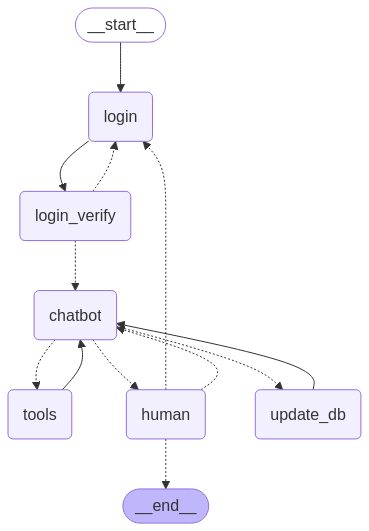

In [23]:
# Update the graph to include the modified login node.
graph_builder = StateGraph(BookState)

graph_builder.add_node("login", login_with_welcome_msg)
graph_builder.add_node("login_verify", login_verify)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tools_node)
graph_builder.add_node("human", human_node)
graph_builder.add_node("update_db", update_db_node)

# Add conditional edges from the login node
graph_builder.add_conditional_edges("login_verify", maybe_route_to_chatbot)
graph_builder.add_conditional_edges("chatbot", maybe_route_to_human)
graph_builder.add_conditional_edges("human", maybe_exit)

# Add edges
graph_builder.add_edge(START, "login")
graph_builder.add_edge("login", "login_verify")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("update_db", "chatbot")
# Compile the updated graph
chat_graph = graph_builder.compile()

# Visualize the updated graph
Image(chat_graph.get_graph().draw_mermaid_png())

In [24]:
state = chat_graph.invoke(({ "messages": [] }))

Welcome to SHELFIE. I can help you find and recommend books with the ability to explore, reserve or waitlist books with ease.You can search by title, description, author, or an excerpt. Let's find your next great read!You must login to reserve or waitlist books. Please provide your user ID and password to login.You can type `q` to quit chatting with me anytime but that would make me sad :(
Login successful! How can I assist you today?
Model: How can I help you today?
